# LSTM 105
Train on short, evaluate on all

In [1]:
from google.colab import drive
PATH='/content/drive/'
drive.mount(PATH)
DATAPATH=PATH+'My Drive/data/'
PC_FILENAME = DATAPATH+'pcRNA.fasta'
NC_FILENAME = DATAPATH+'ncRNA.fasta'
#PC_FILENAME = 'pcRNA.fasta'
#NC_FILENAME = 'ncRNA.fasta'


Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time

dt='float32'
tf.keras.backend.set_floatx(dt)

EPOCHS=200
SPLITS=1
K=4
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
FILENAME='LSTM105'

## Load and partition sequences

In [3]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
def make_train_test(data):
    bin_labels= sizebin(data)
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
    # split(x,y) expects that y is the labels. 
    # Trick: Instead of y, give it it the bin labels that we generated.
    for train_index,test_index in splitter.split(data,bin_labels):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
    return (train_set,test_set)

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)

def make_slice(data_set,min_len,max_len):
    print("original "+str(data_set.shape))
    too_short = data_set[ data_set['seqlen'] < min_len ].index
    no_short=data_set.drop(too_short)
    print("no short "+str(no_short.shape))
    too_long = no_short[ no_short['seqlen'] >= max_len ].index
    no_long_no_short=no_short.drop(too_long)
    print("no long, no short "+str(no_long_no_short.shape))
    return no_long_no_short


## Make K-mers

In [4]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1 -1:  # stop at minus one for spaced seed
            #kmer=seq[i:i+2]+seq[i+3:i+5]    # SPACED SEED 2/1/2 for K=4
            kmer=seq[i:i+K]  
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [5]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)

    # The returned values are Pandas dataframes.
    # print(X_train_all.shape,y_train_all.shape)
    # (X_train_all,y_train_all)
    # y: Pandas dataframe to Python list.
    # y_train_all=y_train_all.values.tolist()
    # The sequences lengths are bounded but not uniform.
    X_train_all
    print(type(X_train_all))
    print(X_train_all.shape)
    print(X_train_all.iloc[0])
    print(len(X_train_all.iloc[0]['sequence']))

    # X: List of string to List of uniform-length ordered lists of K-mers.
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # X: true 2D array (no more lists)
    X_train_kmers.shape

    print("transform...")
    # From pandas dataframe to numpy to list to numpy
    print(type(X_train_kmers))
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    print(type(X_train_kmers))
    print(X_train_kmers)

    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [6]:
def make_frequencies(Xin):
    # Input:  numpy X(numseq,seqlen)  list of vectors of kmerval where val0=NNN,val1=AAA,etc. 
    # Output: numpy X(numseq,65)    list of frequencies of 0,1,etc.
    Xout=[]
    VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            freqs[kmerval] += 1
            total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)

## Build model

In [7]:
def build_model(maxlen):
    vocabulary_size=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
    act="sigmoid"
    dt='float32'

    neurons=16
    dot = 0.50
    rnn = keras.models.Sequential()
    embed_layer = keras.layers.Embedding(
        vocabulary_size,EMBED_DIMEN,input_length=maxlen);
    rnn1_layer = keras.layers.Bidirectional(
        keras.layers.LSTM(neurons, return_sequences=True, dropout=dot, 
            input_shape=[maxlen,EMBED_DIMEN]))
    rnn2_layer = keras.layers.Bidirectional(
        keras.layers.LSTM(neurons, dropout=dot, return_sequences=True))
    dense1_layer = keras.layers.Dense(neurons,activation=act,dtype=dt)
    drop1_layer  = keras.layers.Dropout(dot)
    dense2_layer = keras.layers.Dense(neurons,activation=act,dtype=dt)
    drop2_layer  = keras.layers.Dropout(dot)
    output_layer = keras.layers.Dense(1,activation=act,dtype=dt)

    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(rnn2_layer)
    rnn.add(dense1_layer)
    rnn.add(drop1_layer)
    rnn.add(dense2_layer)
    rnn.add(drop2_layer)
    rnn.add(output_layer)

    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

## Cross validation

In [8]:
def do_cross_validation(X,y,maxlen):
    model = None
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.2, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]

        print("BUILD MODEL")
        model=build_model(maxlen)

        print("FIT")
        start_time=time.time()
        # this is complaining about string to float
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)
                        
        fold += 1
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        # What are the other metrics_names?
        # Try this from Geron page 505:
        # np.mean(keras.losses.mean_squared_error(y_valid,y_pred))
        cv_scores.append(scores[1] * 100)  
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
    return model

In [9]:
def just_train(model,X_train,y_train,maxlen):
    print("FIT")
    start_time=time.time()
    # this is complaining about string to float
    history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
            )  # no validation data
    end_time=time.time()
    elapsed_time=(end_time-start_time)
    print("Train %d epochs, %d sec"%(EPOCHS,elapsed_time))

    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

    #scores = model.evaluate(X_valid, y_valid, verbose=0)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #cv_scores.append(scores[1] * 100)  
    #print()
    #print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
    return model

## Load

In [10]:
print("Load data from files.")
nc_seq=load_fasta(NC_FILENAME,0)
pc_seq=load_fasta(PC_FILENAME,1)
all_seq=pd.concat((nc_seq,pc_seq),axis=0)

print("Put aside the test portion.")
(train_set,test_set)=make_train_test(all_seq)
# Do this later when using the test data:
# (X_test,y_test)=separate_X_and_y(test_set)

nc_seq=None
pc_seq=None
all_seq=None

print("Ready: train_set")
train_set

Load data from files.
Put aside the test portion.
Ready: train_set


,seqnum,class,sequence,seqlen
1280,1281,0,AGTCCCTCCCCAGCCCAGCAGTCCCTCCAGGCTACATCCAGGAGAC...,348
9088,9089,0,CAGCTCCTGGGATGGCCTCACCTGAGGAGACTCTTGGGCCTTGGCA...,534
6069,6070,1,AGATCTAGGGATGGGGATGGGGAGGAGAAGTGGGAATGGGAAATTG...,592
18549,18550,1,GACGTCTCCCGCGGGCGTCGGCAGGGTCGGCGGCGTCGGCAGCAGT...,945
15027,15028,1,GAGCGCGCGAGCCGGGCCCGGAGCGCACGCCGCCGCCGCCACCGCC...,4382
...,...,...,...,...
3386,3387,0,TTTATGTGGATTGTCTGTCTCATGCTTGTTTCACCAGGGTAGTTAC...,578
6495,6496,0,ATAATGGGAAACTAAGGGCAAGTTCTCATGTTCCTGGTCCTGGCTT...,562
6409,6410,1,GGGTTTATTACTACTGAAGGAAGAACGTGAGTAGGTTAGGATTTCG...,740
7640,7641,1,ACAGCTGTGTTTGGCTGCAGGGCCAAGAGCGCTGTCAAGAAGACCC...,3156


# Reuse

Train on lengths 200 to 1000
slice...
original (30290, 4)
no short (30290, 4)
no long, no short (8879, 4)
kmers...
<class 'pandas.core.frame.DataFrame'>
(8879, 1)
sequence    AGTCCCTCCCCAGCCCAGCAGTCCCTCCAGGCTACATCCAGGAGAC...
Name: 1280, dtype: object
348
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[ 46 182 214 ...   0   0   0]
 [ 36 142  56 ...   0   0   0]
 [135  28 110 ...   0   0   0]
 ...
 [147  73  36 ...   0   0   0]
 [228 143  57 ...   0   0   0]
 [131  12  47 ...   0   0   0]]
BUILD MODEL
COMPILE
FIT
Epoch 1/200
278/278 [==============================] - 31s 112ms/step - loss: 0.7202 - accuracy: 0.5014
Epoch 2/200
278/278 [==============================] - 31s 111ms/step - loss: 0.7009 - accuracy: 0.4999
Epoch 3/200
278/278 [==============================] - 31s 111ms/step - loss: 0.6969 - accuracy: 0.4998
Epoch 4/200
278/278 [==============================] - 30s 109ms/step - loss: 0.6955 - accuracy: 0.4987
Epoch 5/200
278/278 [=================

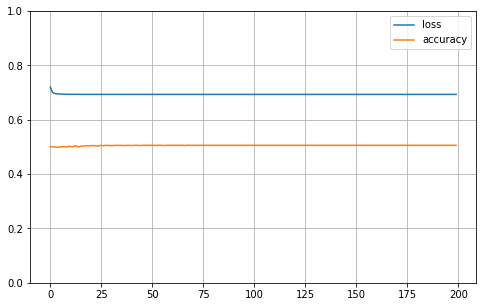

In [11]:
#reload=model1.load(FILENAME+'.short.model')
#W = model1.get_weights()
#scores = model1.evaluate(X_valid, y_valid, verbose=0)
#print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))

min=200
max=1000
print("Train on lengths %d to %d"%(min,max))
print("slice...")
subset=make_slice(train_set,min,max)
print("kmers...")
(X_train,y_train)=make_kmers(max,subset)
print("BUILD MODEL")
model=build_model(max)
model=just_train(model,X_train,y_train,max)




In [12]:
def evaluate(model,min,max):
    print("Evaluate on lengths %d to %d"%(min,max))
    print("slice...")
    subset=make_slice(train_set,min,max)
    print("kmers...")
    (X_valid,y_valid)=make_kmers(max,subset)
    print("evaluate....")
    scores = model.evaluate(X_valid, y_valid, verbose=1)  # valid = train, expect 100%
    print("Evaluated on lengths %d to %d"%(min,max))
    print("%s: %.2f%%\n" % (model.metrics_names[1], scores[1]*100))


In [13]:
evaluate(model,200,1000)
evaluate(model,1000,2000)
evaluate(model,2000,3000)
evaluate(model,3000,5000)
evaluate(model,5000,10000)
evaluate(model,10000,30000)


Evaluate on lengths 200 to 1000
slice...
original (30290, 4)
no short (30290, 4)
no long, no short (8879, 4)
kmers...
<class 'pandas.core.frame.DataFrame'>
(8879, 1)
sequence    AGTCCCTCCCCAGCCCAGCAGTCCCTCCAGGCTACATCCAGGAGAC...
Name: 1280, dtype: object
348
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[ 46 182 214 ...   0   0   0]
 [ 36 142  56 ...   0   0   0]
 [135  28 110 ...   0   0   0]
 ...
 [147  73  36 ...   0   0   0]
 [228 143  57 ...   0   0   0]
 [131  12  47 ...   0   0   0]]
evaluate....
278/278 [==============================] - 16s 59ms/step - loss: 0.6931 - accuracy: 0.5059
Evaluated on lengths 200 to 1000
accuracy: 50.59%

Evaluate on lengths 1000 to 2000
slice...
original (30290, 4)
no short (9273, 4)
no long, no short (3368, 4)
kmers...
<class 'pandas.core.frame.DataFrame'>
(3368, 1)
sequence    GGCGGGGTCGACTGACGGTAACGGGGCAGAGAGGCTGTTCGCAGAG...
Name: 12641, dtype: object
1338
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'n

## Len 200-1Kb

In [14]:
MINLEN=200
MAXLEN=1000

if False:
  print ("Compile the model")
  model=build_model(MAXLEN)
  print ("Summarize the model")
  print(model.summary())  # Print this only once
  print("Working on full training set, slice by sequence length.")
  print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
  subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
  print ("Sequence to Kmer")
  (X_train,y_train)=make_kmers(MAXLEN,subset)
  X_train
  X_train=make_frequencies(X_train)
  X_train
  print ("Cross valiation")
  model1 = do_cross_validation(X_train,y_train,MAXLEN)
  model1.save(FILENAME+'.short.model')

## Len 1Kb-2Kb

In [15]:
MINLEN=1000
MAXLEN=2000

if False:
    print ("Compile the model")
    model=build_model(MAXLEN)
    print ("Summarize the model")
    print(model.summary())  # Print this only once
    print("Working on full training set, slice by sequence length.")
    print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
    subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
    print ("Sequence to Kmer")
    (X_train,y_train)=make_kmers(MAXLEN,subset)
    X_train
    X_train=make_frequencies(X_train)
    X_train
    print ("Cross valiation")
    model2 = do_cross_validation(X_train,y_train,MAXLEN)
    model2.save(FILENAME+'.medium.model')

## Len 2Kb-3Kb

In [16]:
MINLEN=2000
MAXLEN=3000

if False:
    print ("Compile the model")
    model=build_model(MAXLEN)
    print ("Summarize the model")
    print(model.summary())  # Print this only once
    print("Working on full training set, slice by sequence length.")
    print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
    subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
    print ("Sequence to Kmer")
    (X_train,y_train)=make_kmers(MAXLEN,subset)
    X_train
    X_train=make_frequencies(X_train)
    X_train
    print ("Cross valiation")
    model3 = do_cross_validation(X_train,y_train,MAXLEN)
    model3.save(FILENAME+'.long.model')